# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
*  игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:

      hit  — взять ещё одну карту;
      stand — не брать больше карт;

* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

Рассмотрим очень простую стратегию: 
1. говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех 
остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
3. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
4. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [1]:
import os
if not os.path.isfile('blackjack.py'):
  !wget https://raw.githubusercontent.com/openai/gym/master/gym/envs/toy_text/blackjack.py

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
Шаги
from blackjack import BlackjackEnv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Базовая версия игры Блэкджек, в которой есть только 2 действия: hit и stand.

In [3]:
def run_episode(env, pi):
    env.reset()
    states, rewards, actions = [env._get_obs()], [0], []

    for _ in range(50):
        action = pi(env)
        observation, reward, done, info = env.step(action)
        states.append(observation)
        rewards.append(reward)
        actions.append(action)
            
        if done:
            break

    return states, rewards, actions

In [4]:
def run_experiments(env, pi, num_experiments=100_000):
    num_steps, total_reward = np.array([0.0] * num_experiments), np.array([0.0] * num_experiments)

    for i in range(num_experiments):
        states, rewards, _ = run_episode(env, pi)
        num_steps[i] = len(states) - 1
        total_reward[i] = rewards[-1]

    mean_reward = np.mean(total_reward)
    mean_steps = np.mean(num_steps)
Шаги
    print("Reward:", mean_reward)
    print("Steps:", mean_steps)

    return mean_reward, mean_steps

Попробуем оценить выигрыш казино в случае, когда игрок будет делать случайные действия.

In [5]:
def random_pi(env):
    return np.int(np.random.rand() * 2)

In [6]:
env = BlackjackEnv()
run_experiments(env, random_pi);

Reward: -0.39265
Steps: 1.37367


 Казино забирает 0.4 ставки
 

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

In [7]:
def smart_pi(env):
    player, dealer, usable_ace = env._get_obs()
    return np.int(player < 19)

In [8]:
env = BlackjackEnv()
run_experiments(env, smart_pi);

Reward: -0.19601
Steps: 1.74971


Выгода казино в два раза меньше

## Monte Carlo Exploring States

Начинаем генерировать эпизоды по случайной стратегии. В каждом эпизоде обходя позиции с конца запоминать полученную награду для каждого действия. Если  действие не соответствовало стратегии, обработка эпизода прекращается. 

Затем периодически обновлять свою стратегию по имеющимся оценкам:

* Для известных позиций по каждому действию вычисляется средняя полученная награда. Нерассмотренные действия оцениваются нулем.
* С небольшим шансом делается случайное действие, чтобы сохранить возможность исследовать окружение. Если позиция известна - выбирается наилучшее действие по оценкам награды. Иначе - случайное действие.

В таком случае при небольшом количестве возможных стостояний мы сможем в начале получить достаточно опыта. 

Далее нужно больше следовать выбранной стратегии, поэтому случайная стратегия постепенно заменяется на мягкую. Таким образом оценки получаются довольно точными т.к. игра неглубокая и очень редко когда бывает больше 2 ходов у игрока.

In [9]:
def update_returns_actions(rewards_list, states, rewards, actions):
    for i in range(len(states) - 2, -1, -1):
        state = states[i]
        try:
            rewards_list[state][actions[i]].append(rewards[-1])
        except:
            rewards_list[state] = [[0], [0]]
            rewards_list[state][actions[i]].append(rewards[-1])
        
        actions_reward = np.array([np.mean(action) for action in rewards_list[state]])        
        if not(np.argmax(actions_reward) == actions[i]):
            break


def calc_Q_by_reward(rewards_list):
    Q = {}
    for state, actions in rewards_list.items():
        Q[state] = np.array([np.mean(action) for action in actions])
    return Q


def calc_pi_by_reward(rewards_list):
    pi = {}
    for state, actions in rewards_list.items():
        actions_reward = np.array([np.mean(action) for action in actions])
        pi[state] = np.argmax(actions_reward)
    return pi
 
pi = {}
def monte_carlo_pi(env):
    try:
        return pi[env._get_obs()]
    except:
        return random_pi(env)


def eps_monte_carlo_pi(env):
    eps = 0.05
    if np.random.rand() < eps:
        return random_pi(env)

    try:
        return pi[env._get_obs()]
    except:
        return random_pi(env)


def plot_results(mean_rewards, mean_num_steps, episodes):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax2 = ax.twinx()
    ax.grid(None)

    line1 = ax.plot(episodes, mean_rewards, label="Reward", color="C0")
    line2 = ax2.plot(episodes, mean_num_steps, label="Steps", color="C1")

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=2)
    ax.set_xlim((episodes[0], episodes[-1]))
    ax.set_title("Monte Carlo Exploring States")
    return fig, ax

In [10]:
env = BlackjackEnv()
total_episodes = 500_000
total_points = 10 + 1

mean_rewards, mean_num_steps = np.array([0.0] * total_points), np.array([0.0] * total_points) 
episodes = np.arange(0, total_episodes + 1, total_episodes // (total_points - 1))

reward_list = {}
pi = {}
j = 0

for i in range(total_episodes + 1):
    states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
    update_returns_actions(reward_list, states, rewards, actions)

    if i % (total_episodes // (total_points - 1)) == 0:
        print(f"Episode: {i}")
        pi = calc_pi_by_reward(reward_list)
        mean_rewards[j], mean_num_steps[j] = run_experiments(env, monte_carlo_pi)
        j += 1

Episode: 0
Reward: -0.39758
Steps: 1.37361
Episode: 50000
Reward: -0.07214
Steps: 1.38321
Episode: 100000
Reward: -0.06724
Steps: 1.40499
Episode: 150000
Reward: -0.06284
Steps: 1.42533
Episode: 200000
Reward: -0.05998
Steps: 1.42273
Episode: 250000
Reward: -0.05637
Steps: 1.42842
Episode: 300000
Reward: -0.0619
Steps: 1.45695
Episode: 350000
Reward: -0.05846
Steps: 1.45619
Episode: 400000
Reward: -0.05344
Steps: 1.46066
Episode: 450000
Reward: -0.05326
Steps: 1.47799
Episode: 500000
Reward: -0.05497
Steps: 1.47904


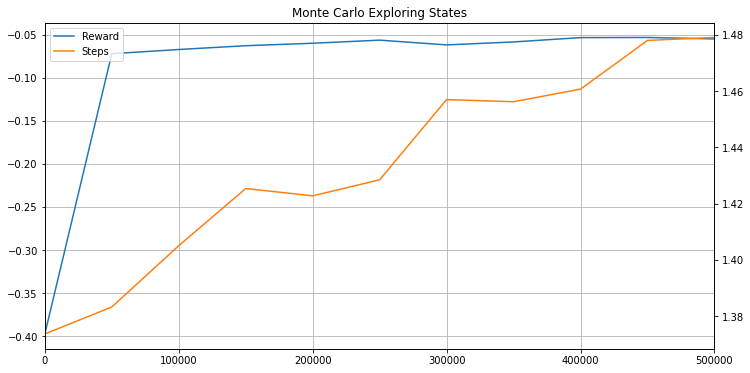

In [11]:
plot_results(mean_rewards, mean_num_steps, episodes);

Cтратегия сходится к тому, что казино выигрывает 0.05 ставки

## Часть вторая, удвоенная

Добавим возможность использовать действие double в окружении

In [12]:
def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand): 
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand): 
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand): 
    return sum_hand(hand) > 21


def score(hand): 
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand): 
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
                
        else:  
            if action == 2: # для удвоения ставки
                self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if action == 2: # для удвоения ставки
                reward *= 2
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [13]:
env = BlackjackEnv(True)

In [14]:
run_experiments(env, smart_pi);

Reward: -0.17511
Steps: 1.74922


In [15]:
def update_returns_actions(rewards_list, states, rewards, actions):
    for i in range(len(states) - 2, -1, -1):
        state = states[i]
        try:
            rewards_list[state][actions[i]].append(rewards[-1])
        except:
            rewards_list[state] = [[0], [0], [0]]
            rewards_list[state][actions[i]].append(rewards[-1])
        
        actions_reward = np.array([np.mean(action) for action in rewards_list[state]])        
        if not(np.argmax(actions_reward) == actions[i]):
            break


def random_pi(env):

    return np.int(np.random.rand() * 3)

In [16]:
env = BlackjackEnv()
total_episodes = 500_000
total_points = 10 + 1

mean_rewards, mean_num_steps = np.array([0.0] * total_points), np.array([0.0] * total_points) 
episodes = np.arange(0, total_episodes + 1, total_episodes // (total_points - 1))

reward_list = {}
pi = {}
j = 0

for i in range(total_episodes + 1):
    states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
    update_returns_actions(reward_list, states, rewards, actions)

    if i % (total_episodes // (total_points - 1)) == 0:
        print(f"Episode: {i}")
        pi = calc_pi_by_reward(reward_list)
        mean_rewards[j], mean_num_steps[j] = run_experiments(env, monte_carlo_pi)
        j += 1

Episode: 0
Reward: -0.47028
Steps: 1.22495
Episode: 50000
Reward: -0.08967
Steps: 1.18994
Episode: 100000
Reward: -0.07676
Steps: 1.24243
Episode: 150000
Reward: -0.07527
Steps: 1.25335
Episode: 200000
Reward: -0.0662
Steps: 1.25701
Episode: 250000
Reward: -0.06536
Steps: 1.28292
Episode: 300000
Reward: -0.0611
Steps: 1.29004
Episode: 350000
Reward: -0.05529
Steps: 1.30545
Episode: 400000
Reward: -0.05184
Steps: 1.31034
Episode: 450000
Reward: -0.06277
Steps: 1.31065
Episode: 500000
Reward: -0.05173
Steps: 1.31629


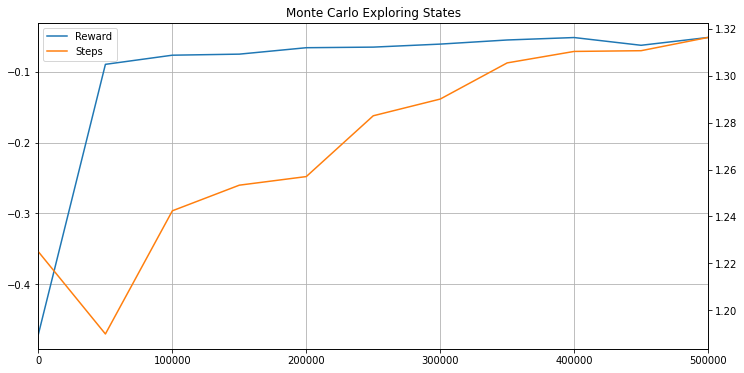

In [17]:
plot_results(mean_rewards, mean_num_steps, episodes);

Немного лучше, но совсем чуть-чуть